# Preexperiment Setup

## 1 Experiment setup

For details about the physical experiment setup see the system_details notebook.

### 1.1 Quick checklist

Before starting a series of experiments, 

    - the balls need to be cleaned in detergent, water, de-ionised water and dried. Leave on a metal sieve. 
    - The surface needs a light clean with IPA and a cloth but don't rub too hard. 
    - Check the sandblasting still looks fresh.

Fill system with particles about the number shown below:

<div> <img src="imgs/level_starting.jpg" alt="Drawing" style="width: 300px;"/></div>

## 2 Define system boundary

Start by defining the boundary of the experiment using this code. Click on each corner of the boundary in the image and then press spacebar. *Only necessary if you'ved moved something*

<div> <img src="imgs/boundary_pts.png" alt="Drawing" style="width: 300px;"/></div>

**It is important to know that as the shaker is tilted by the motors, the selected boundary and hence mid point of the shaker will move slightly**. If you need it super flat you may need to go through the process twice. ie run the levelling, then reselect boundary points and refine motor limits before relevelling.

In [2]:
from shaker.balance import find_boundary
from labvision.camera import Camera
from labvision.camera.camera_config import CameraType
from shaker.balance import update_settings_file

panasonic = CameraType.PANASONICHCX1000
with Camera(cam_type=panasonic) as cam:
    boundary_pts = find_boundary(cam, shape='polygon')
    update_settings_file(boundary_pts=boundary_pts)

#Output is a list of tuples corresponding to the boundary points and the centroid
print(boundary_pts)

(((459, 22), (859, 23), (1056, 366), (859, 708), (462, 711), (263, 369)), 659.6666666666666, 366.5)


## 3 Check stepper motor communication and get experiment approx manual level

### 3.1 Stepper motor comms

The stepper motors can be a bit temperamental. Run the next cell to check that the motors are working. They move very slowly so look carefully. 
The issue is to do with the serial communication. If the motors are not moving, try the following fixes in this order:
    
    1. Try restarting the kernel
    
    2. Restart the arduino and the computer. Switch off DC power supply to arduino when restarting

### 3.2 Manual level

Don't touch the leg with the bolt but with the shaker off and a spirit level on experiment surface adjust the legs to get the surface reasonably level. You don't need to worry too much about this, just get it roughly right. The axes and direction are shown in the image below. The positive direction is the way the balls will move in the image.

In [2]:
from shaker.balance import draw_img_axes
from labvision.images import display
from labvision.images import draw_circle
from labvision.camera import Camera
from labvision.camera.camera_config import CameraType
# This settings dictionary defines params for shaker and com_balls processing fn.
from shaker.centre_mass import com_balls, SETTINGS_com_balls 
from shaker.balance import update_settings_file


panasonic = CameraType.PANASONICHCX1000
with Camera(cam_type=panasonic) as cam:
    img = cam.get_frame()
    #find centre of mass of balls in image
    boundary_pts = update_settings_file()['boundary_pts'][0]
    x,y = com_balls(img, boundary_pts, img_settings=SETTINGS_com_balls['img_processing'])
    #plot measured centre of mass of balls on image
    img = draw_circle(img, int(x), int(y), rad=4, color=(0,0,255), thickness=-1)
    #draw coordinate axes on image
    img = draw_img_axes(img)
    display(img)

In [2]:
from shaker.stepperXY import StepperXY

with StepperXY() as motors:
    motors.movexy(0,0)


stepperxy init
port closed


## 4 Set Motor Limits

Movements in x and y ~ +/- 15000 seem enough to tip the shaker from one side to the other. You may bottom out the motors if not careful so make sure you know which way things are moving. You want one limit above and left and one below and right. You are trying to tell the system the motor limits that create a square box on the surface that it should search in. 

<div> <img src="imgs/level.png" alt="Drawing" style="width: 300px;"/></div>

*You only need to run this if not already set*. The system records the current motor position to a file so it will persist between experiments. However, if for example you crash some code when the motor has been told to move it could get out of sync. 

In [ ]:
## Set motor limits
from shaker.balance import Balancer
from shaker.stepperXY import StepperXY
from shaker.shaker import Shaker
from shaker.centre_mass import com_balls
from labvision.camera import Camera
from labvision.camera.camera_config import CameraType


panasonic = CameraType.PANASONICHCX1000

with Shaker() as shaker, StepperXY() as motors, Camera(cam_type=panasonic) as cam:
    bal=Balancer(shaker, cam, motors, measure_fn=com_balls)
    motor_limits = bal.set_motor_limits(set_limits=True)
    bal.disp.close_window()


## Levelling the shaker

When levelling system use the same balls being used for the experiments. The balls need to be cleaned in detergent, water, de-ionised water and dried. The levelling uses the 4k Video Capture card to take pictures of the tray. These images are processed using a function that works out where the centre of mass of all the particles in the tray is. At the start the user defines where the centre is by clicking the corners of the boundary. The system then moves the motors systematically to try and minimise the distance between the true centre of tray and centre of mass of particles.

`initial_iterations` is the number of measurements per position to determine the centre of mass. Increase if the flucutations between images are too high.
`ncalls` is how many steps it will take to try and level the system.

## Leaving the system to get on with it

*General Warning*

The magnet that drives the shaker has a warming up period. Run the shaker at a dutycycle of 550 with the water cooler on for 120 mins before starting experiments. If you skip this step your accelerations won't be correctly calibrated to the duty_cycles.

Before running the automated setup it is worth doing checks. Are all bits talking to the computer correctly! Switch on the water bath etc and start the shaker running then set the delay_timer at the top, hit run and leave it to get on with it. Check the shaker's toggle switch  is on. Don't forget to press the relay button on the back of the power supply. My personal favourite mistake!

This code assumes you have already set the boundary points and the motor limits.

1. The system will wait for delay_timer_hours with the shaker duty_cycle at 0
2. The system will then warm up for 2 hours at a duty_cycle of 500
3. The system will level itself (probably take a long time!)
4. The system will collect an acceleration calibration curve
5. You can come in and start work (hopefully ;-)

The heart of the levelling is <a href="https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html">skopt.gp_minimize</a>, although our code uses a fork of this code which contains a few datatype fixes (<a href="www.github.com/mikesmithlabteam/skopt">our version</a>.)

You need to set the parameters:

`iterations`    :   How many times the measurement will be performed to obtain the average x,y before moving the motors to a new position

`ncalls`        :   How many times the motors will be moved to try and find the best position

You also need to decide on the `delay_timer_hours` and `warm_timer_hours`

100%|██████████| 30/30 [2:17:08<00:00, 274.28s/it]


port closed
port closed
Shaker communication closed
Optimum motor position is (7835,-2215) with cost : 42.1894903046343
Setup time: 8252.795021057129 seconds


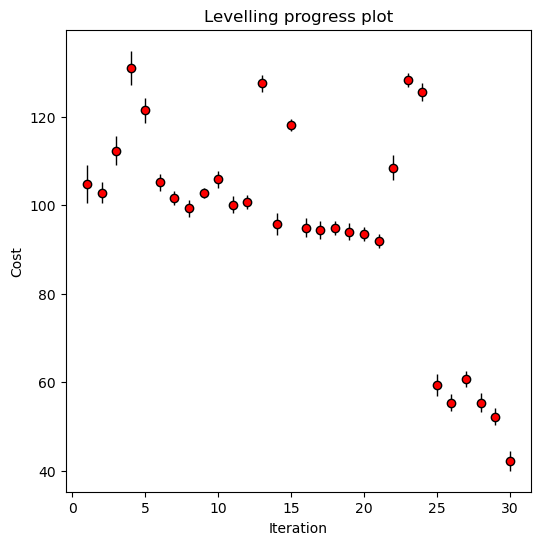

In [1]:
import time

from shaker.shaker import Shaker
from shaker.balance import Balancer
from shaker.stepperXY import StepperXY
from shaker.shaker import Shaker
from shaker.centre_mass import com_balls
from labvision.camera import Camera
from labvision.camera.camera_config import CameraType
from shaker.balance import update_settings_file

# Delays the setup by x hours then warms for 2 hours
delay_timer_hours = 0
warm_timer_hours = 0#update_settings_file()['shaker_warmup_hours']
warm_up_shaker_amplitude = update_settings_file()['shaker_warmup_duty']


def start_expt_setup(delay_timer_hours):
    for i in range(delay_timer_hours):
        print('Starting expt setup in ' + str(delay_timer_hours - i) + ' hours')
        time.sleep(3600)

print('levelling...')
panasonic = CameraType.PANASONICHCX1000 #creating camera object.

start_time = time.time()

with Shaker() as shaker, StepperXY() as motors, Camera(cam_type=panasonic) as cam:
    shaker.set_duty(0)
    start_expt_setup(delay_timer_hours)
    shaker.set_duty(warm_up_shaker_amplitude)
    start_expt_setup(warm_timer_hours)
    bal=Balancer(shaker, cam, motors, measure_fn=com_balls)
    result = bal.level(iterations=10, ncalls=30)

finish_time = time.time()

print("Optimum motor position is (" + str(result.x[0]) + "," + str(result.x[1]) + ") with cost : " + str(result.fun))
print('Setup time: ' + str(finish_time - start_time) + ' seconds')
    

## Refining

If you need things very level you may want to repeat the process.

    1. Rerun the boundary_pts code at the top
    2. run the refine_motor_limits code below
    3. run the levelling code again

In [ ]:
from shaker.centre_mass  import refine_motor_limits

#This uses the track_levelling file to set some tight limits around the original centre point.
refine_motor_limits()


## Check level

This next step is for looking at the output of the levelling. How well did it do? The system will plot the cost function at each point and the final level of the system as a function of motor position. Do all the points lie on a single surface?

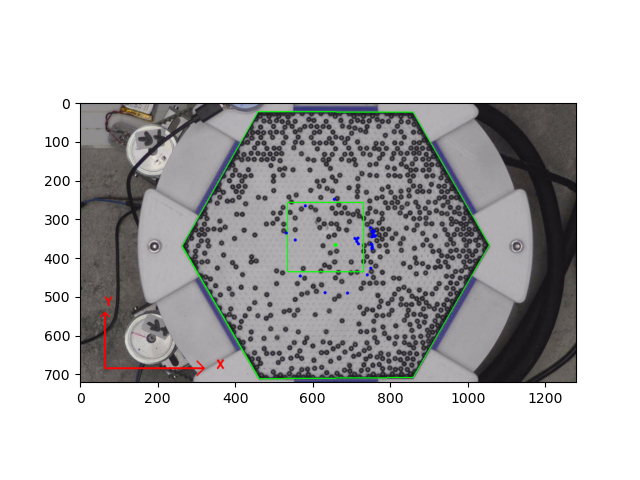

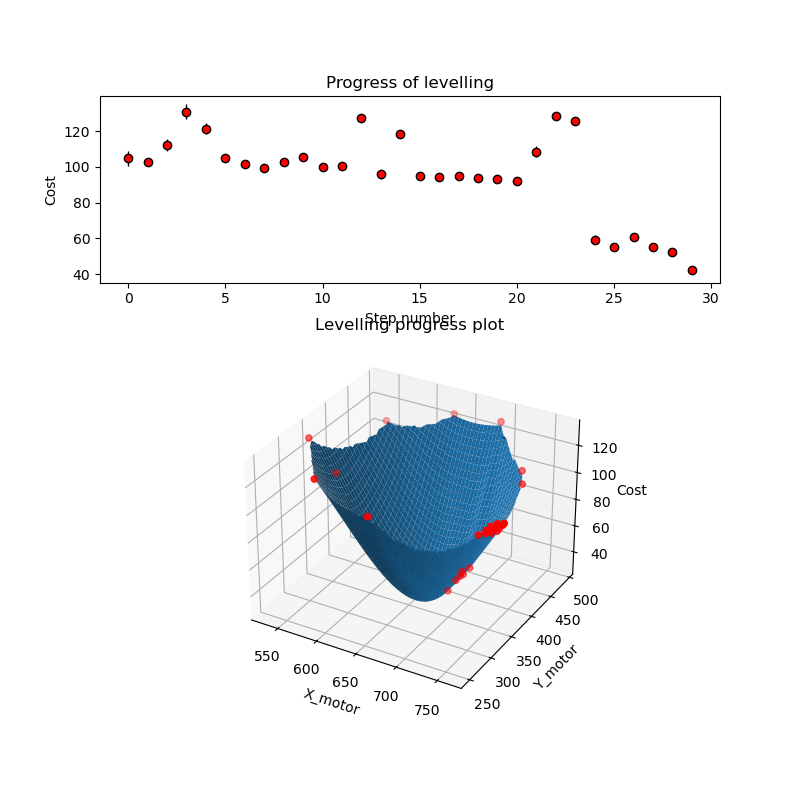

In [2]:
%matplotlib widget
from shaker.centre_mass import plot_levelling
from shaker.settings import SETTINGS_PATH, TRACK_LEVEL


plot_levelling(SETTINGS_PATH, TRACK_LEVEL, TRACK_LEVEL[:-4] + '.png')


### Calibrating the system and accelerometer

Run a script to collect duty cycles and corresponding measured peak accelerations from the RPI-LCD (i.e $\Gamma = a\omega^{2}/g$). The output file will be used in particle tracker to convert the duty cycle to the corresponding acceleration. The code on the RPI-LCD is in the <a href="https://github.com/mikesmithlab/Accelerometer">Accelerometer</a> repository. The code is not universal since each accelerometer has to be calibrated. Calibrated accelerometers are marked and the uf2 files should be labelled accordingly. <a href="https://github.com/MikeSmithLabTeam/labequipment/blob/master/labequipment/accelerometer.py">Labequipment</a> has python code to interface with and read results.

shaker init


100%|██████████| 17/17 [01:51<00:00,  6.55s/it]


port closed
port closed
Shaker communication closed
Calibration time: 121.92936420440674 seconds


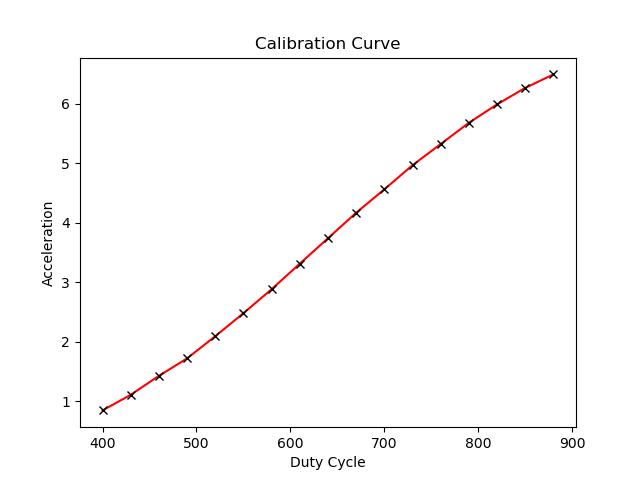

In [1]:
%matplotlib widget
import pandas as pd
import time

from shaker.calibrate_accelerometer import calibrate_accelerometer, plot_acceleration_calibration
from shaker.settings import SETTINGS_PATH, ACCELEROMETER_FILE


start_time = time.time()

duty_cycles, acceleration = calibrate_accelerometer(start=400, stop=900, step=30)
pd.DataFrame({'duty_cycle': duty_cycles, 'acceleration': acceleration}).to_csv(SETTINGS_PATH + ACCELEROMETER_FILE, index=False)

finish_time = time.time()
print('Calibration time: ' + str(finish_time - start_time) + ' seconds')

plot_acceleration_calibration()

### 1.2 Setup filestructure

Use the next set of code to setup your filestructure etc. The filepath and naming are automatic and linked to date so that you can easily find your data and know that everything relevant is grouped together. A automatic script runs to backup the data to the NAS in this folder every night.

In [2]:
import os
import datetime
import shutil
from shaker.settings import SETTINGS_PATH, TRACK_LEVEL, ACCELEROMETER_FILE

project_filepath = 'E:/RawData/Mike/Intruders/Intruder_expts/'
date_folder = datetime.datetime.now().strftime('%Y_%m_%d')

#Don't want to overwrite by accident
if not os.path.isdir(project_filepath + date_folder + '/'):
    #Setup new folders
    os.mkdir(project_filepath +date_folder + '/')
    calibration_folder = project_filepath + date_folder + '/Calibrations/'
    os.mkdir(project_filepath + date_folder + '/Calibrations/')

    #Copy all levelling files to project folder/Calibrations
    shutil.copy(SETTINGS_PATH + TRACK_LEVEL[:-4] + '.png', calibration_folder  + TRACK_LEVEL[:-4] + '_' + date_folder + '.png')
    shutil.copy(SETTINGS_PATH + TRACK_LEVEL, calibration_folder  + TRACK_LEVEL[:-4] + '_' + date_folder + '.txt')
    shutil.copy(SETTINGS_PATH + ACCELEROMETER_FILE , calibration_folder  + ACCELEROMETER_FILE[:-4] + '_' + date_folder + '.txt')
    
    print("Setting up new experimental folder : ", project_filepath + date_folder)
else:
    print("Folder already exists, no files copied.")


Setting up new experimental folder :  E:/RawData/Mike/Intruders/Intruder_expts/2024_04_17
